# Викишоп

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

    Цель: 

    *   Обучите модель классифицировать комментарии на позитивные и негативные. 
        В вашем распоряжении набор данных с разметкой о токсичности правок.
    *   Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Библиотеки

In [ ]:
#!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Импортируем библиотеки.

In [ ]:
import en_core_web_sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string

И все используемое далее.

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

Отключаем лишние предупреждения.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Функции

#### column_values

In [ ]:
def column_values(data_frame):
    '''
    Функция для визуального поиска артефактов и выбросов в значениях DataFrame
    '''
    for column in data_frame.columns:
        print('\nЗначения столбца', column,':')
        print(data_frame[column].sort_values().unique())

#### df_info

In [ ]:
def df_info(data_frame):
    '''
    Функция выводящая первичную информацию о DataFrame
    '''
    print('\nРазмер таблицы: {} '.format(data_frame.shape))
    print('\nИнфо:')
    print(data_frame.info())                                            # сколько значений и в каком формате
    print('\nПропусков:')
    print(data_frame.isna().mean().sort_values(ascending=False) * 100)  # подсчёт пропусков в процентах
    print('\nОписание:')
    display(data_frame.describe())                                      # вдруг чего "на глазок" проявится 
    print('\nДубликатов =', data_frame.duplicated().sum())              # проверим дубликаты

#### lemmatization

In [ ]:
def lemmatization(text):
    '''
    Функция приводит слова к начальной форме
    '''
    temp = []
    for token in nlp(text):
        if token.is_stop == False:
            temp.append(token.lemma_)
    return " ".join(temp)

#### mess_info

In [ ]:
def mess_info(df, stopwords):
    '''
    Функция добавляет в DataFrame информацию о сообщениях
    '''
  # Количество слов
    df['word'] = df['text'].apply(lambda x: len(str(x).split()))
  # Количество уникальных слов
    df['unique_word'] = df['text'].apply(lambda x: len(set(str(x).split())))
  # Количетво стоп слов
    df['stop_word'] = df['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords]))
  # Количество ссылок
    df['url'] = df['text'].apply(lambda x: len([word for word in str(x).lower().split() if 'http' in word or 'https' in word]))
  # Средняя длина слова
    df['word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
  # Количество символов
    df['characters'] = df['text'].apply(lambda x: len(str(x)))
  # Количество знаков препинания
    df['punctuation'] = df['text'].apply(lambda x: len([symbol for symbol in str(x) if symbol in string.punctuation]))
    
    return df

#### text_cleaning

In [ ]:
def text_cleaning(text):
    '''
    Функция подчищающая текст с помощью регулярных выражений (Модуль Re)
    '''
    text = re.sub(r"(?:\n|\r)",
                  " ",
                  text)             # удаляем символы \n \r
    text = re.sub(r"[^a-zA-Z ]+",
                  "",
                  text).strip()     # выбираем только слова
    text = text.lower()             # все буквы к нижнему регистру
    return text

### Константы

In [ ]:
random_state = 1980
cv = 5

### Таблица

Читаем файл с данными и сохраняем в df.

In [ ]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except Exception:
    ! gdown --id "Вырезано цензурой"
    df = pd.read_csv('/content/toxic_comments.csv')

Смотрим табличку.

In [ ]:
display(df.columns)
print()
display(df.sample(15, random_state=random_state))

Index(['text', 'toxic'], dtype='object')

,text,toxic
43854,They have a contract with a club. They have no...,0
111613,What do you need help with? Algebraist,0
145586,I still stand by my opinions Raul.,0
92552,BOBBY WEAVER WENT TO EASTON HIGH SCHOOL NOT BL...,0
29091,"""\n\n Some assistance, please \n\nUser:Appletr...",0
6489,"""\n Your submission at Articles for creation \...",0
134320,you're an asshole,1
124177,An imprssive enough feat for teenagers back in...,0
127944,"""\nWhy is it weasely? Weasel words are to be ...",0
119790,"""\n\n 2 plant species called Mile-a-minute wee...",0


Посмотрим заполненость таблицы.

In [ ]:
df_info(df)


Размер таблицы: (159571, 2) 

Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None

Пропусков:
text     0.0
toxic    0.0
dtype: float64

describe:


,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Дубликатов = 0


### Вывод

    - Вроде бы все "ровно", но токсичных комментариев маловато.
    
Посмотрим:


Дисбаланс 1 токсичный пост на 8.834884437596301 не токсичных.



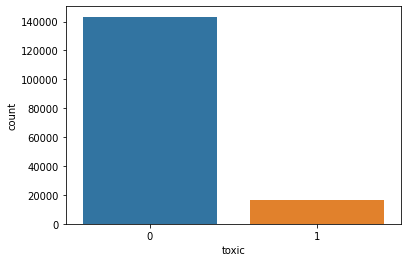

In [ ]:
sns.countplot(x = 'toxic', data = df)

imbalance = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
print('\nДисбаланс: 1 токсичный пост на', imbalance, 'не токсичных.\n')

## Анализ

Отлавливаем артефакты в данных.

In [ ]:
column_values(df)


Значения столбца text :
["!\n\nI won't stop!  LOCK IT UP A$$HOLE"
 '!\n\nIt is now inside your bones, your head. Haunt you forever'
 "!\n\nSuck my DIHCK! Nihgga!\n\nYou don't want people to know the TRUTH about utorrant, you FAG"
 ...
 "只, is it correctly written in the picture of the calligraphy?  I would say it isn't.  It is replaced by the wrong word 隻."
 '这是什么意思？\n\nYou have been blocked from editing.\n62.194.166.79 (your account, your IP address or a range of addresses) was blocked by Jpgordon for the following reason (see our blocking policy):\ntor\n\nYour IP address is 62.194.166.79, and your block has been set to expire: indefinite.'
 "\ufeffSensual Pleasures of the MindItalic text\n\nThere are endless creative ways to provoke and capture sensual feelings. Money can’t buy it, you can’t see it or hold it, outer\npackaging offers no competition for it and no grandiose flash of materialistic presence can incite it. Sensuality in it’s truest sense can only be felt within.  It is p

С `toxic` все хорошо, а `text` посмотрим по другому.

In [ ]:
with pd.option_context('display.max_rows', 11):
    display(pd.Series(df['text'].sort_values().unique()).to_frame().rename(columns={0 : 'Пост'}))

,Пост
0,!\n\nI won't stop! LOCK IT UP A$$HOLE
1,"!\n\nIt is now inside your bones, your head. H..."
2,!\n\nSuck my DIHCK! Nihgga!\n\nYou don't want ...
3,!\n\nWHY DOESN'T ANYONE BAN ME \n\nBAN ME BAN ...
4,!\nPlease stop reverting my edits to Wesley Ho...
...,...
159566,"➥the Epopt]] 14:00, 8 May"
159567,北京 \n\nI am going to reinstate the weatherbox ...
159568,"只, is it correctly written in the picture of t..."
159569,这是什么意思？\n\nYou have been blocked from editing....


Добавим информации о сообщениях.

In [ ]:
%%time
# Wall time: 28.4 s
df = mess_info(df, STOP_WORDS)
display(df)

,Unnamed: 0,text,toxic,word,unique_word,stop_word,url,word_length,characters,punctuation,cleared_text,text_lemm
0,0,Explanation\nWhy the edits made under my usern...,0,43,41,19,0,5.162791,264,10,explanation why the edits made under my userna...,explanation edit username hardcore metallica f...
1,1,D'aww! He matches this background colour I'm s...,0,17,17,2,0,5.588235,112,12,daww he matches this background colour im seem...,daww match background colour m seemingly stuck...
2,2,"Hey man, I'm really not trying to edit war. It...",0,42,39,21,0,4.571429,233,6,hey man im really not trying to edit war its j...,hey man m try edit war guy constantly remove r...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,113,82,61,0,4.486726,622,21,more i cant make any real suggestions on impro...,not real suggestion improvement wonder secti...
4,4,"You, sir, are my hero. Any chance you remember...",0,13,13,5,0,4.230769,67,5,you sir are my hero any chance you remember wh...,sir hero chance remember page s
...,...,...,...,...,...,...,...,...,...,...,...,...
159566,159566,""":::::And for the second time of asking, when ...",0,47,44,22,0,5.212766,295,18,and for the second time of asking when your vi...,second time ask view completely contradict cov...
159567,159567,You should be ashamed of yourself \n\nThat is ...,0,18,18,12,0,4.388889,99,4,you should be ashamed of yourself that is a ...,ashamed horrible thing talk page
159568,159568,"Spitzer \n\nUmm, theres no actual article for ...",0,12,12,2,0,5.583333,81,4,spitzer umm theres no actual article for pro...,spitzer umm s actual article prostitution r...
159569,159569,And it looks like it was actually you who put ...,0,25,23,17,0,3.680000,116,1,and it looks like it was actually you who put ...,look like actually speedy version delete look


CPU times: user 11.6 s, sys: 37.7 ms, total: 11.6 s
Wall time: 11.6 s


Посмотрим зависимости токсичности от новых параметров.

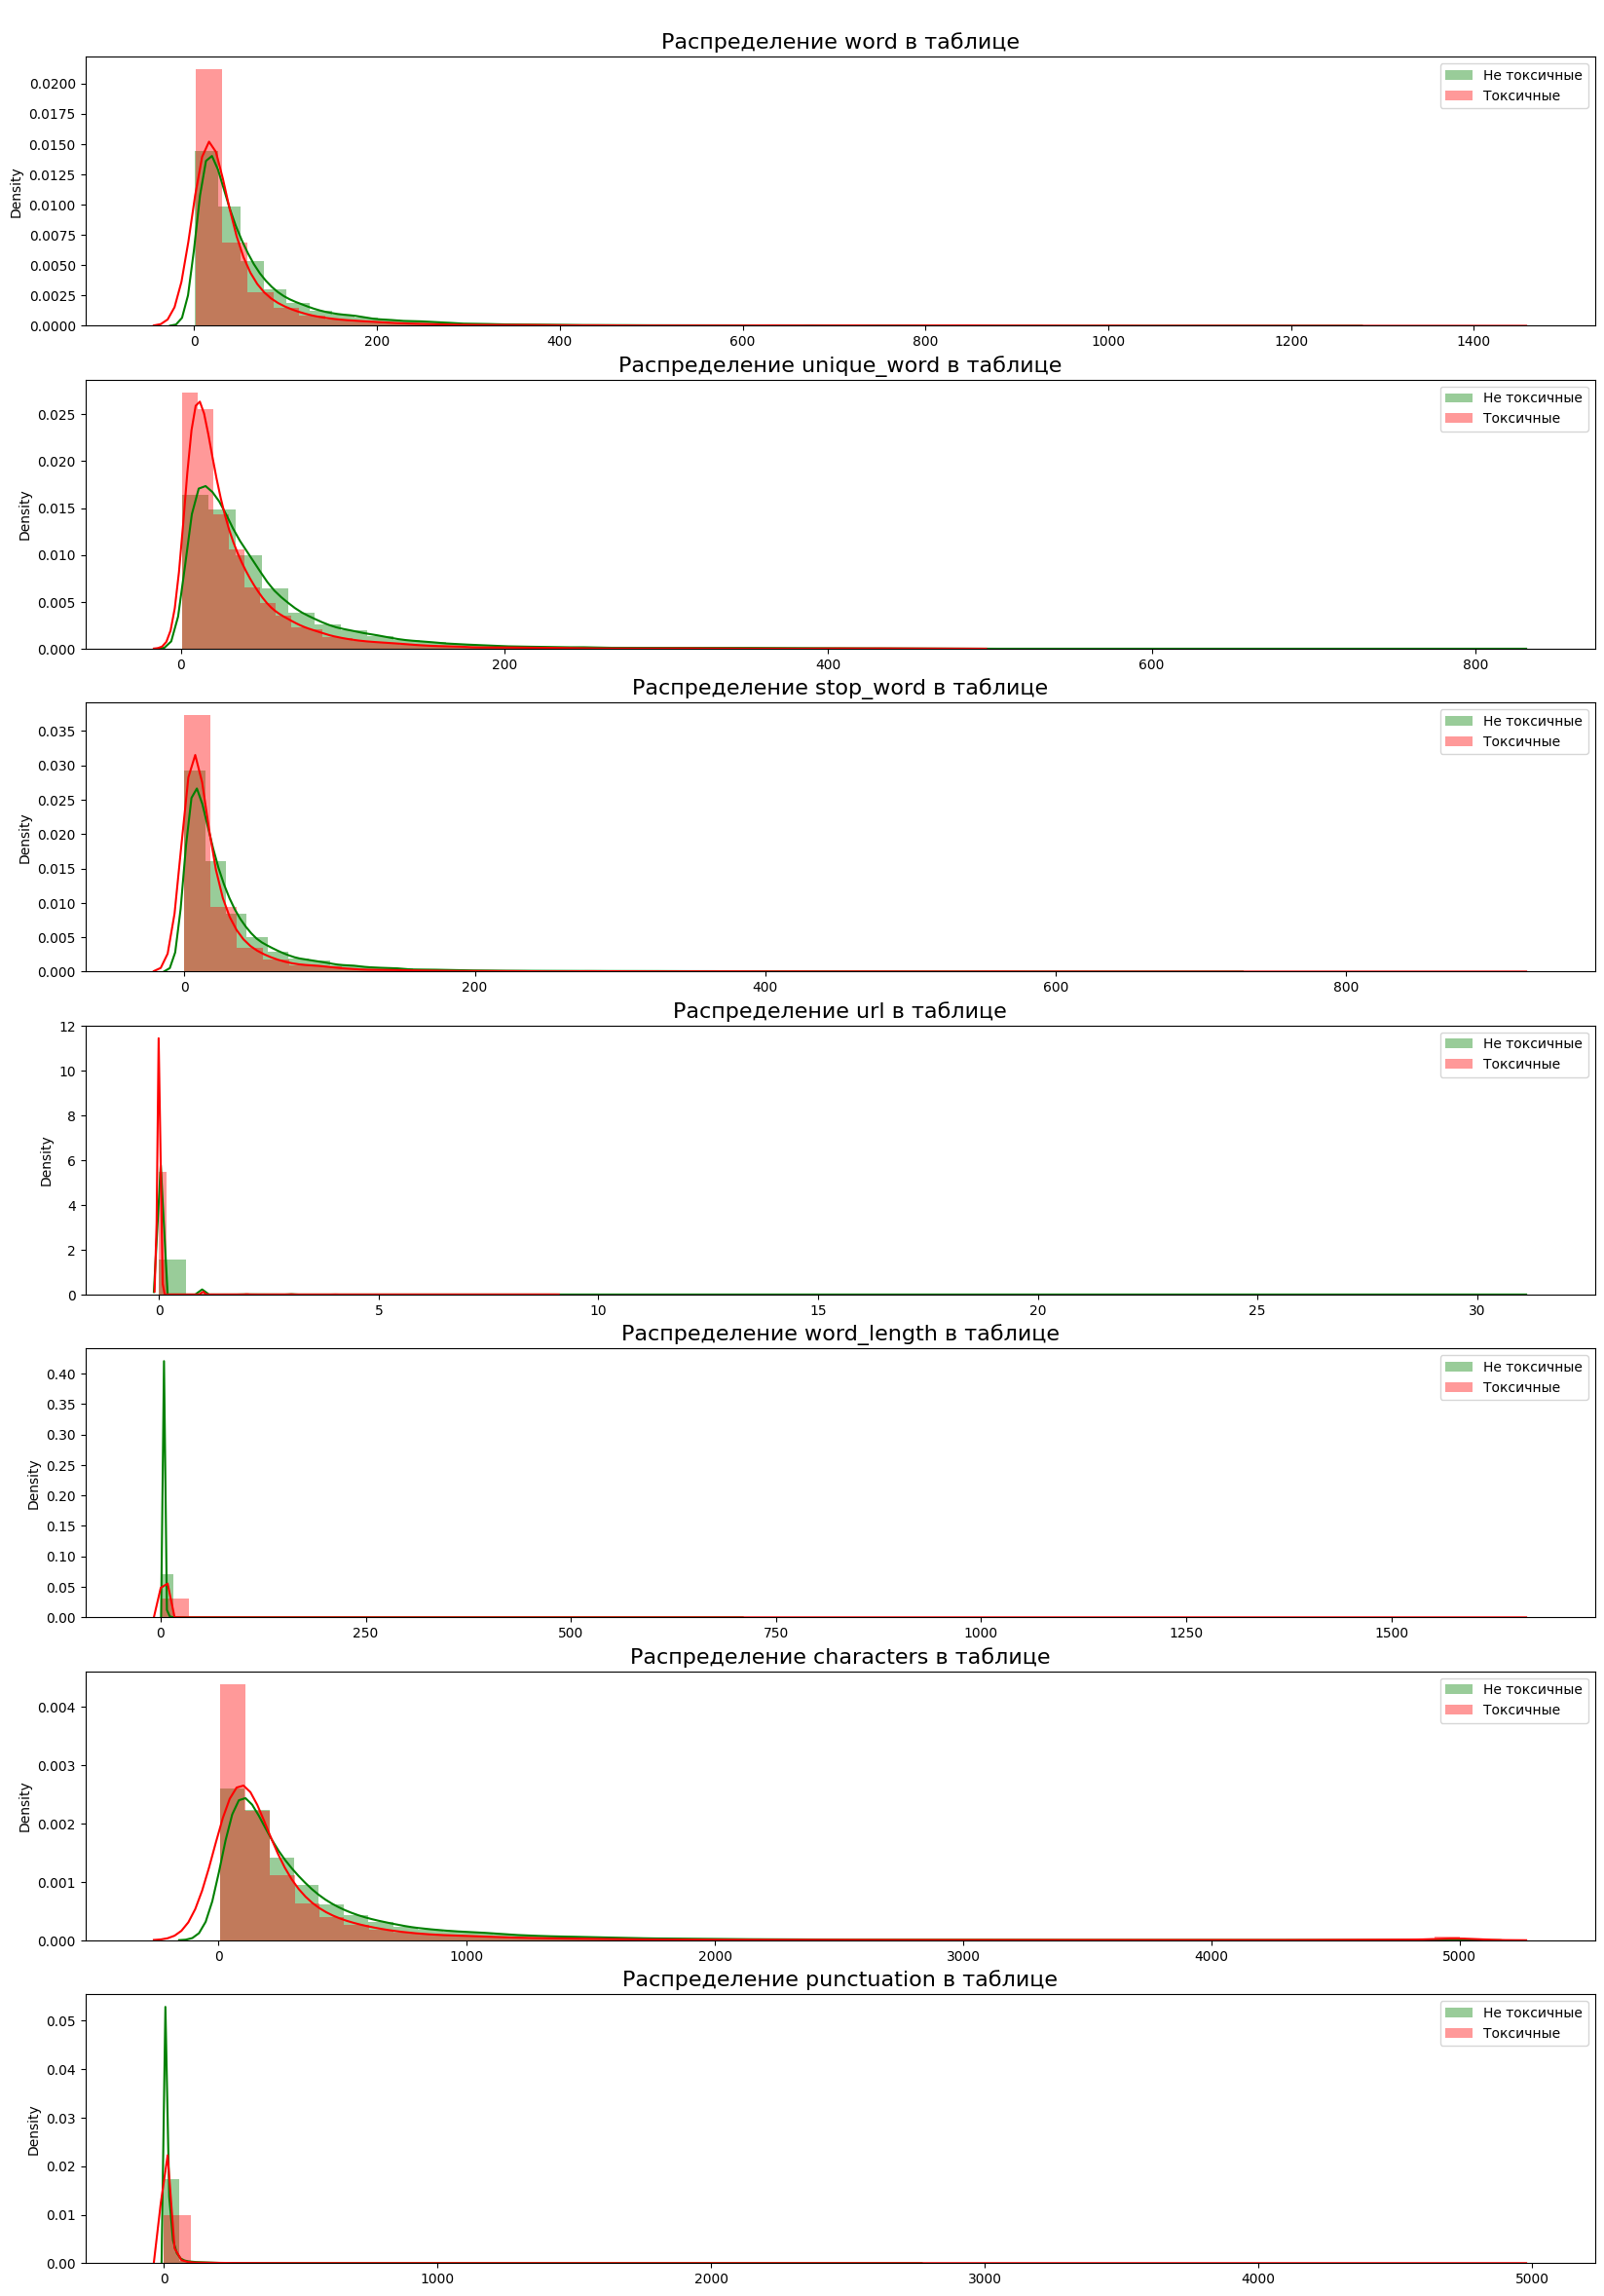

CPU times: user 6.97 s, sys: 1.67 s, total: 8.64 s
Wall time: 8.66 s


In [ ]:
%%time
new_features = ['word',
                'unique_word',
                'stop_word',
                'url',
                'word_length',
                'characters',
                'punctuation']
toxic = df['toxic'] == 1
fig, axes = plt.subplots(ncols=1,
                         nrows=len(new_features),
                         figsize=(20, 30),
                         dpi=100)
for i, feature in enumerate(new_features):
    sns.distplot(df.loc[~toxic][feature],
                 label='Не токсичные',
                 ax=axes[i],
                 color='green')
    sns.distplot(df.loc[toxic][feature],
                 label='Токсичные',
                 ax=axes[i],
                 color='red')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x',
                        labelsize=10)
    axes[i].tick_params(axis='y',
                        labelsize=10)
    axes[i].legend()

    axes[i].set_title(f'\nРаспределение {feature} в таблице',
                      fontsize=16)
plt.show()

Посмотрим корреляцию признаков.

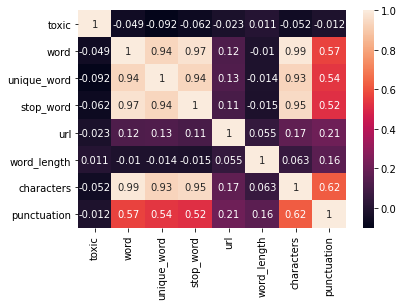

In [ ]:
sns.heatmap(df.corr(),
            vmin=-0.1,
            vmax=1,
            annot=True);

### Вывод

Токсичные сообщения

    злоупотребляют
        - уникальными словами
        - ссылками
    не любят
        - длинные слова
        - пунктуацию
        
Возможно получился избыток признаков: `word`, `unique_word`, `stop_word` и `characters` сильно коррелируют между собой.

## Обработка данных

### Чистка 

In [ ]:
# Уменьшим количество признаков с высокой корреляцией
#features = df.drop(#['word'],
                    #['unique_word'],
                    #['stop_word'],
                    #['characters'],
#                   axis=1)

Почистим тексты.

In [ ]:
df['cleared_text'] = df['text'].apply(text_cleaning)
df[['text', 'cleared_text']].sample(15, random_state=random_state)

,text,cleared_text
43854,They have a contract with a club. They have no...,they have a contract with a club they have no ...
111613,What do you need help with? Algebraist,what do you need help with algebraist
145586,I still stand by my opinions Raul.,i still stand by my opinions raul
92552,BOBBY WEAVER WENT TO EASTON HIGH SCHOOL NOT BL...,bobby weaver went to easton high school not bl...
29091,"""\n\n Some assistance, please \n\nUser:Appletr...",some assistance please userappletrees is per...
6489,"""\n Your submission at Articles for creation \...",your submission at articles for creation her...
134320,you're an asshole,youre an asshole
124177,An imprssive enough feat for teenagers back in...,an imprssive enough feat for teenagers back in...
127944,"""\nWhy is it weasely? Weasel words are to be ...",why is it weasely weasel words are to be avoi...
119790,"""\n\n 2 plant species called Mile-a-minute wee...",plant species called mileaminute weed there ...


### Лемматизация

In [ ]:
# Wall time: 1h 31min 18s
'''
%%time
# Лемматизируем текст с помощью spacy
nlp = en_core_web_sm.load()
tqdm.pandas()
df['text_lemm'] = df['cleared_text'].progress_apply(lemmatization)
'''

"\n%%time\n# Лемматизируем текст с помощью spacy\nnlp = en_core_web_sm.load()\ntqdm.pandas()\ndf['text_lemm'] = df['cleared_text'].progress_apply(lemmatization)\n"

In [ ]:
'''
# Сохраним полученный датафрейм, чтобы можно было обходить долгий расчет.
export_csv = df.to_csv(r'data_prepared_file.csv')
'''

"\nexport_csv = df.to_csv(r'data_prepared_file.csv')\n"

Подгружаем уже рассчитанный файл.

In [ ]:
try:
    df = pd.read_csv('data_prepared_file.csv')
except Exception:
    ! gdown --id 1AI5SrWyRqB974a4-mZpravvS5Ur98AHq
    df = pd.read_csv('/content/data_prepared_file.csv')

In [ ]:
df.sample(15, random_state=random_state)

,Unnamed: 0,text,toxic,word,unique_word,stop_word,url,word_length,characters,punctuation,cleared_text,text_lemm
43854,43854,They have a contract with a club. They have no...,0,15,10,10,0,4.600000,83,2,they have a contract with a club they have no ...,contract club contract international
111613,111613,What do you need help with? Algebraist,0,7,7,3,0,4.571429,38,1,what do you need help with algebraist,need help algebraist
145586,145586,I still stand by my opinions Raul.,0,7,7,4,0,4.000000,34,1,i still stand by my opinions raul,stand opinion raul
92552,92552,BOBBY WEAVER WENT TO EASTON HIGH SCHOOL NOT BL...,0,18,17,7,0,4.333333,95,4,bobby weaver went to easton high school not bl...,bobby weaver go easton high school blair acade...
29091,29091,"""\n\n Some assistance, please \n\nUser:Appletr...",0,19,18,10,0,5.631579,131,8,some assistance please userappletrees is per...,assistance userappletree persistently accus...
6489,6489,"""\n Your submission at Articles for creation \...",0,120,81,64,0,4.758333,700,21,your submission at articles for creation her...,submission article creation herbine arkansa...
134320,134320,you're an asshole,1,3,3,1,0,5.000000,17,1,youre an asshole,asshole
124177,124177,An imprssive enough feat for teenagers back in...,0,17,17,9,0,4.882353,99,5,an imprssive enough feat for teenagers back in...,imprssive feat teenager making selling featu...
127944,127944,"""\nWhy is it weasely? Weasel words are to be ...",0,66,56,36,0,4.166667,347,13,why is it weasely weasel words are to be avoi...,weasely weasel word avoid push point view ...
119790,119790,"""\n\n 2 plant species called Mile-a-minute wee...",0,95,78,35,0,5.789474,653,44,plant species called mileaminute weed there ...,plant specie call mileaminute weed specie c...


### Подготовка данных

Разделим выборку в соотношении 70/30.

In [ ]:
target = df['toxic']
features = df.drop(['toxic'],
                    axis = 1)
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.3,
                                                                            stratify = target,
                                                                            random_state = random_state)

Создадим счётчик, указав в нём стоп-слова.

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words = STOP_WORDS)

Векторизуем тексты.

In [ ]:
%%time
features_train = count_tf_idf.fit_transform(features_train['text_lemm'].apply(lambda x: np.str_(x)))
features_test = count_tf_idf.transform(features_test['text_lemm'].apply(lambda x: np.str_(x)))
print('features_train', features_train.shape)
print('features_test', features_test.shape)

features_train (111699, 161180)
features_test (47872, 161180)
CPU times: user 4.56 s, sys: 76.4 ms, total: 4.64 s
Wall time: 4.63 s


Данные для обучения подготовлены. 160 тыс. признаков - это серьезно.

## Обучение

* переставляя знак `'''` можно менять активацию расчет/ответ

### CatBoostClassifier

In [ ]:
%%time
# Wall time: 39min 41s
'''
classificator_cbc = CatBoostClassifier(verbose = False,
                                       iterations = 200,
                                       learning_rate = 0.15,
                                       random_state = random_state)
classificator_cbc.fit(features_train,
                      target_train,
                      plot = True)
f1_cbc = cross_val_score(classificator_cbc,
                         features_train, 
                         target_train, 
                         cv = cv, 
                         scoring = 'f1').mean().round(5)
print('\nF1 на CatBoostClassifier =', f1_cbc)
print()
'''
f1_cbc = 0.71
print('\nF1 на CatBoostClassifier =', f1_cbc)
print()



F1 на CatBoostClassifier = 0.71

CPU times: user 83 µs, sys: 12 µs, total: 95 µs
Wall time: 100 µs


### DecisionTreeClassifier

In [ ]:
classificator_dtc = DecisionTreeClassifier()

In [ ]:
%%time
# Wall time: 14min 3s
'''
hyperparams = [{#'max_depth':[x for x in range(1, 83, 2)],
                'max_depth':[x for x in range(76, 83, 2)],
                'random_state':[random_state]}]
grid_dtc = GridSearchCV(classificator_dtc,
                        hyperparams,
                        scoring = 'f1',
                        cv = cv)
grid_dtc.fit(features_train,
             target_train)
best_params_dtc = grid_dtc.best_params_
print('\nЛучший набор параметров:\n', best_params_dtc)
means = grid_dtc.cv_results_['mean_test_score']
f1_dtc = max(means).round(5)
print('\nF1 на DecisionTreeClassifier =', f1_dtc)
print()
'''
best_params_dtc = {'max_depth': 80,
                   'random_state': random_state}
f1_dtc = 0.71
print('\nF1 на DecisionTreeClassifier =', f1_dtc)
print()



F1 на DecisionTreeClassifier = 0.71

CPU times: user 210 µs, sys: 5 µs, total: 215 µs
Wall time: 151 µs


### LGBMClassifier

In [ ]:
classificator_lgbmc = LGBMClassifier()

In [ ]:
%%time
# Wall time: 1h 47min 40s
'''
hyperparams = [{'n_estimators':[100, 300, 600],
                #'n_estimators':[600],
                'max_depth':[10, 50, 100],
                #'max_depth':[10],
                'class_weight':['balanced'],
                'random_state':[random_state]
              }]
grid_lgbmc = GridSearchCV(classificator_lgbmc,
                          hyperparams,
                          scoring = 'f1',
                          cv = cv)
grid_lgbmc.fit(features_train,
               target_train)
best_params_lgbmc = grid_lgbmc.best_params_
print('\nЛучший набор параметров:\n', best_params_lgbmc)
means = grid_lgbmc.cv_results_['mean_test_score']
f1_lgbmc = max(means).round(5)
print('\nF1 на LGBMClassifier =', f1_lgbmc)
print()
'''
best_params_lgbmc = {'n_estimators': 600,
                      'max_depth': 10,
                      'class_weight': 'balanced',
                      'random_state': random_state}
f1_lgbmc = 0.76
print('\nF1 на LGBMClassifier =', f1_lgbmc)
print()



F1 на LGBMClassifier = 0.76

CPU times: user 440 µs, sys: 24 µs, total: 464 µs
Wall time: 329 µs


### LogisticRegression

In [ ]:
%%time
# Без балансировки классов F1= 0,68
regressor_lr = LogisticRegression(class_weight = 'balanced')
train_f1_lr = cross_val_score(regressor_lr,
                              features_train,
                              target_train,
                              cv = cv,
                              scoring = 'f1').mean().round(5)
print('F1 на CV =', train_f1_lr)

F1 на CV со сбалансированными классами 0.75
CPU times: user 28.7 s, sys: 28.7 s, total: 57.3 s
Wall time: 30.3 s


In [ ]:
%%time
# Wall time: 2min 8s
'''
hyperparams = [{#'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'solver':['lbfgs'],
                #'C':[1, 3, 5, 10, 50],
                'C':[5],
                'random_state':[random_state]
               }]
grid_lr = GridSearchCV(regressor_lr,
                       hyperparams,
                       scoring = 'f1',
                       cv = cv)
grid_lr.fit(features_train,
            target_train)
best_params_lr = grid_lr.best_params_
print('\nЛучший набор параметров:\n', best_params_lr)
means = grid_lr.cv_results_['mean_test_score']
f1_lr = max(means).round(5)
print('\nF1 на LogisticRegression =', f1_lr)
print()
'''
best_params_lr = {'C': 5,
                  'random_state': 1980,
                  'solver': 'lbfgs'}
f1_lr = 0.77
print('\nF1 на LogisticRegression =', f1_lr)
print()



F1 на LogisticRegression = 0.77

CPU times: user 29 µs, sys: 1.68 ms, total: 1.71 ms
Wall time: 1.96 ms


### RandomForestClassifier

In [ ]:
classificator_rfc = RandomForestClassifier(class_weight = 'balanced')

In [ ]:
%%time
# Wall time: 50min 10s
'''
hyperparams = [{#'max_depth':[5, 10, 15, 20],
                'max_depth':[20],
                #'n_estimators':[50, 100, 150, 200],
                'n_estimators':[100],
                'random_state':[random_state]
              }]
grid_rfc = GridSearchCV(classificator_rfc,
                         hyperparams,
                         scoring = 'f1',
                         cv = cv)
grid_rfc.fit(features_train,
            target_train)
best_params_rfc = grid_rfc.best_params_
print('\nЛучший набор параметров:\n', best_params_rfc)
means = grid_rfc.cv_results_['mean_test_score']
f1_rfc = max(means).round(5)
print('\nF1 на RandomForestClassifier =', f1_rfc)
print()
'''
best_params_rfc = {'max_depth': 20,
                   'n_estimators': 100,
                   'random_state': random_state}
f1_rfc = 0.41
print('\nF1 на RandomForestClassifier =', f1_rfc)
print()



F1 на RandomForestClassifier = 0.41

CPU times: user 5.56 ms, sys: 2.24 ms, total: 7.8 ms
Wall time: 5.33 ms


### SGDClassifier

In [ ]:
classificator_sgdc = SGDClassifier()

In [ ]:
%%time
hyperparams = [{#'loss':['hinge', 'log', 'modified_huber'],
                'loss':['modified_huber'],
                #'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'learning_rate':['constant'],
                #'eta0':[0.01, 0.1, 0.2, 0.3, 0.5],
                'eta0':[0.2],
                'class_weight':['balanced'],
                'random_state':[random_state]
              }]
grid_sgdc = GridSearchCV(classificator_sgdc,
                         hyperparams,
                         scoring = 'f1',
                         cv = cv)
grid_sgdc.fit(features_train,
              target_train)
best_params_sgdc = grid_sgdc.best_params_
print('\nЛучший набор параметров:\n', best_params_sgdc)
means = grid_sgdc.cv_results_['mean_test_score']
f1_sgdc = max(means).round(5)
print('\nF1 на SGDClassifier =', f1_sgdc)
print()
'''
best_params_sgdc = {'loss': 'modified_huber',
                     'learning_rate': 'constant',
                     'eta0': 0.2,
                     'class_weight': 'balanced',
                     'random_state': random_state}
f1_sgdc = 0.64
print('\nF1 на SGDClassifier =', f1_sgdc)
print()
'''


Лучший набор параметров:
 {'class_weight': 'balanced', 'eta0': 0.2, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 1980}

F1 на SGDClassifier = 0.64

CPU times: user 1.81 s, sys: 555 ms, total: 2.37 s
Wall time: 1.71 s


### Результат

In [ ]:
index = ['CatBoostClassifier',
         'DecisionTreeClassifier',
         'LGBMClassifier',
         'LogisticRegression',
         'RandomForestClassifier',
         'SGDClassifier']
data = {'F1':[f1_cbc,
              f1_dtc,
              f1_lgbmc,
              f1_lr,
              f1_rfc,
              f1_sgdc]}
pivot = pd.DataFrame(data = data,
                     index = index)
pivot['Выполнение задачи'] = pivot['F1'] > 0.75
display(pivot)

,F1,Выполнение задачи
CatBoostClassifier,0.71,False
DecisionTreeClassifier,0.71,False
LGBMClassifier,0.76,True
LogisticRegression,0.77,True
RandomForestClassifier,0.41,False
SGDClassifier,0.64,False


## Тестирование

### DecisionTreeClassifier

In [ ]:
%%time
# Wall time: 6min 43s
'''
classificator_dtc.set_params(**best_params_dtc)
classificator_dtc.fit(features_train,
                      target_train)
predict_test_dtc = classificator_dtc.predict(features_test)
f1_dtc_test = f1_score(target_test,
                       predict_test_dtc).round(5)
print('\nF1 на SGDClassifier =', f1_dtc_test, '\n')
'''
f1_dtc_test = 0.71
print('\nF1 на SGDClassifier =', f1_dtc_test)
print()



F1 на SGDClassifier = 0.71

CPU times: user 3.91 ms, sys: 0 ns, total: 3.91 ms
Wall time: 3.76 ms


### DummyClassifier

Модель заполняемая случайно, служит для проверки вменяемости остальных моделей.

In [ ]:
%%time
# Wall time: 38.6 ms
classificator_dc = DummyClassifier(strategy = "constant",
                                   constant = [1],
                                   random_state = random_state)
classificator_dc.fit(features_train,
                     target_train)
predict_test_dc = classificator_dc.predict(features_test)
f1_dc_test = f1_score(target_test,
                      predict_test_dc).round(5)
print('\nF1 на DummyClassifier =', f1_dc_test, '\n')


F1 на DummyClassifier = 0.18 

CPU times: user 32.5 ms, sys: 80 µs, total: 32.6 ms
Wall time: 38.6 ms


### KNeighborsClassifier

In [ ]:
%%time
# Wall time: 2min 55s
'''
classificator_knc = KNeighborsClassifier()
classificator_knc.fit(features_train,
                      target_train)
predict_test_knc = classificator_knc.predict(features_test)
f1_knc_test = f1_score(target_test,
                       predict_test_knc).round(5)
print('\nF1 на KNeighborsClassifier =', f1_knc_test, '\n')
'''
f1_knc_test = 0.33
print('\nF1 на SGDClassifier =', f1_knc_test, '\n')
print()



F1 на SGDClassifier = 0.33

CPU times: user 84 µs, sys: 35 µs, total: 119 µs
Wall time: 124 µs


### LGBMClassifier

In [ ]:
%%time
# Wall time: 3min 29s
'''
classificator_lgbmc.set_params(**best_params_lgbmc)
classificator_lgbmc.fit(features_train,
                    target_train)
predict_test_lgbmc = classificator_lgbmc.predict(features_test)
f1_lgbmc_test = f1_score(target_test,
                         predict_test_lgbmc).round(5)
print('\nF1 на LinearRegression =', f1_lgbmc_test, '\n')
'''
f1_lgbmc_test = 0.76
print('\nF1 на LGBMClassifier =', f1_lgbmc_test, '\n')
print()



F1 на LinearRegression = 0.76 

CPU times: user 3min 17s, sys: 512 ms, total: 3min 18s
Wall time: 3min 29s


### LogisticRegression

In [ ]:
%%time
# Wall time: 8.44 s
regressor_lr.set_params(**best_params_lr)
regressor_lr.fit(features_train,
                 target_train)
predict_test_lr = regressor_lr.predict(features_test)
f1_lr_test = f1_score(target_test,
                      predict_test_lr).round(5)
print('\nF1 на LinearRegression =', f1_lr_test, '\n')


F1 на LinearRegression = 0.77 

CPU times: user 8.43 s, sys: 8.9 s, total: 17.3 s
Wall time: 9.01 s


### RandomForestClassifier

In [ ]:
%%time
# Wall time: 15min 57s
'''
classificator_rfc = RandomForestClassifier(class_weight = 'balanced')
#classificator_rfc.set_params(**best_params_rfc)
classificator_rfc.fit(features_train,
                      target_train)
predict_test_rfc = classificator_rfc.predict(features_test)
f1_rfc_test = f1_score(target_test,
                       predict_test_rfc).round(5)
print('\nF1 на RandomForestClassifier =', f1_rfc_test, '\n')
'''
f1_rfc_test = 0.67
print('\nF1 на RandomForestClassifier =', f1_rfc_test, '\n')



F1 на RandomForestClassifier = 0.67 

CPU times: user 1.47 ms, sys: 0 ns, total: 1.47 ms
Wall time: 1.49 ms


### SGDClassifier

In [ ]:
%%time
classificator_sgdc.set_params(**best_params_sgdc)
classificator_sgdc.fit(features_train,
                       target_train)
predict_test_sgdc = classificator_sgdc.predict(features_test)
f1_sgdc_test = f1_score(target_test,
                        predict_test_sgdc).round(5)
print('\nF1 на SGDClassifier =', f1_sgdc_test, '\n')


F1 на SGDClassifier = 0.67 

CPU times: user 476 ms, sys: 51.2 ms, total: 527 ms
Wall time: 535 ms


### SVC

In [ ]:
%%time
# 
'''
classificator_svc = SVC()
classificator_svc.fit(features_train,
                      target_train)
predict_test_svc = classificator_svc.predict(features_test)
f1_svc_test = f1_score(target_test,
                  predict_test_svc).round(5)
print('\nF1 на SVC =', f1_svc_test, '\n')

f1_svc_test = 0.00
print('\nF1 на SVC =', f1_svc_test, '\n')
'''

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


"\nclassificator_svc = SVC()\nclassificator_svc.fit(features_train,\n                      target_train)\npredict_test_svc = classificator_svc.predict(features_test)\nf1_svc_test = f1_score(target_test,\n                  predict_test_svc).round(2)\nprint('\nF1 на SVC =', f1_svc_test, '\n')\n\nf1_svc_test = 0.00\nprint('\nF1 на SVC =', f1_svc_test, '\n')\n"

### Результат

In [ ]:
index = ['CatBoostClassifier',
         'DecisionTreeClassifier',
         'DummyClassifier',
         'KNeighborsClassifier',
         'lgbmc',
         'LogisticRegression',
         'RandomForestClassifier',
         'SGDClassifier',
         'SVC']
data = {'F1_train':[f1_cbc,
                    f1_dtc,
                    0,
                    0,
                    f1_lgbmc,
                    f1_lr,
                    f1_rfc,
                    f1_sgdc,
                    0],
        'F1_test':[0,
                   f1_dtc_test,
                   f1_dc_test,
                   f1_knc_test,
                   f1_lgbmc_test,
                   f1_lr_test,
                   f1_rfc_test,
                   f1_sgdc_test,
                   0]}
pivot = pd.DataFrame(data = data,
                     index = index)
pivot['Выполнение задачи'] = pivot['F1_test'] > 0.75
display(pivot)

,F1_train,F1_test,Выполнение задачи
CatBoostClassifier,0.71,0.00,False
DecisionTreeClassifier,0.71,0.71,False
DummyClassifier,0.00,0.18,False
KNeighborsClassifier,0.00,0.33,False
lgbmc,0.76,0.76,True
LogisticRegression,0.77,0.77,True
RandomForestClassifier,0.41,0.67,False
SGDClassifier,0.64,0.67,False
SVC,0.00,0.00,False


## Выводы

В проекте исследованы 159571 комментирий клиентов. 

Были протестированы 7 моделей прогнозирования негативности/токсичности сообщений. 
Для двух из них удалось подобрать параметры, которые обеспечили требуемую точность предсказания в *F1* не меньше 0.75.

Лучшей оказалась модель LogisticRegression с *F1* на обучающей выборке = 0.77.



* по модели *BERT* воспользовался условием необязательности.